In [8]:
import numpy as np
import pandas as pd
import sys
import os
import pickle
import warnings
import time
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# SKLEARN IMPORTS
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
sns.set(style="whitegrid")
%matplotlib inline

# --- CONFIGURATION ---
DATA_PATH = "Crop and fertilizer dataset.csv" # Ensure this file exists
OUTPUT_FILENAME = "fertilizer_recommendation_pipeline.pkl"
TARGET_COL = 'Fertilizer'
RANDOM_SEED = 42

print("All standard libraries and configuration loaded.")

All standard libraries and configuration loaded.


In [15]:
# --- 1. Import *CORRECTED* Custom Classifiers ---
# ❗ **ACTION REQUIRED**: Update CLASSIFIER_DIR to the path containing your custom classifier files.
CLASSIFIER_DIR = './' 

if CLASSIFIER_DIR not in sys.path:
    sys.path.append(os.path.abspath(CLASSIFIER_DIR))

try:
    # These MUST be the _FIXED versions you renamed
    from RandomForest import RandomForestClassifier
    from MultiLayerPerceptron import SimpleMLP
    print("Custom classifiers imported successfully.")
except ImportError as e:
    print(f"❌ ERROR: Could not import custom classifiers: {e}")
    print("Please ensure RandomForest.py and MultiLayerPerceptron.py are in the correct path.")
    # Note: We won't exit here, but model training will fail if classes aren't found.
except Exception as e:
    print(f"❌ ERROR: A problem occurred in the custom classifier files: {e}")

Custom classifiers imported successfully.


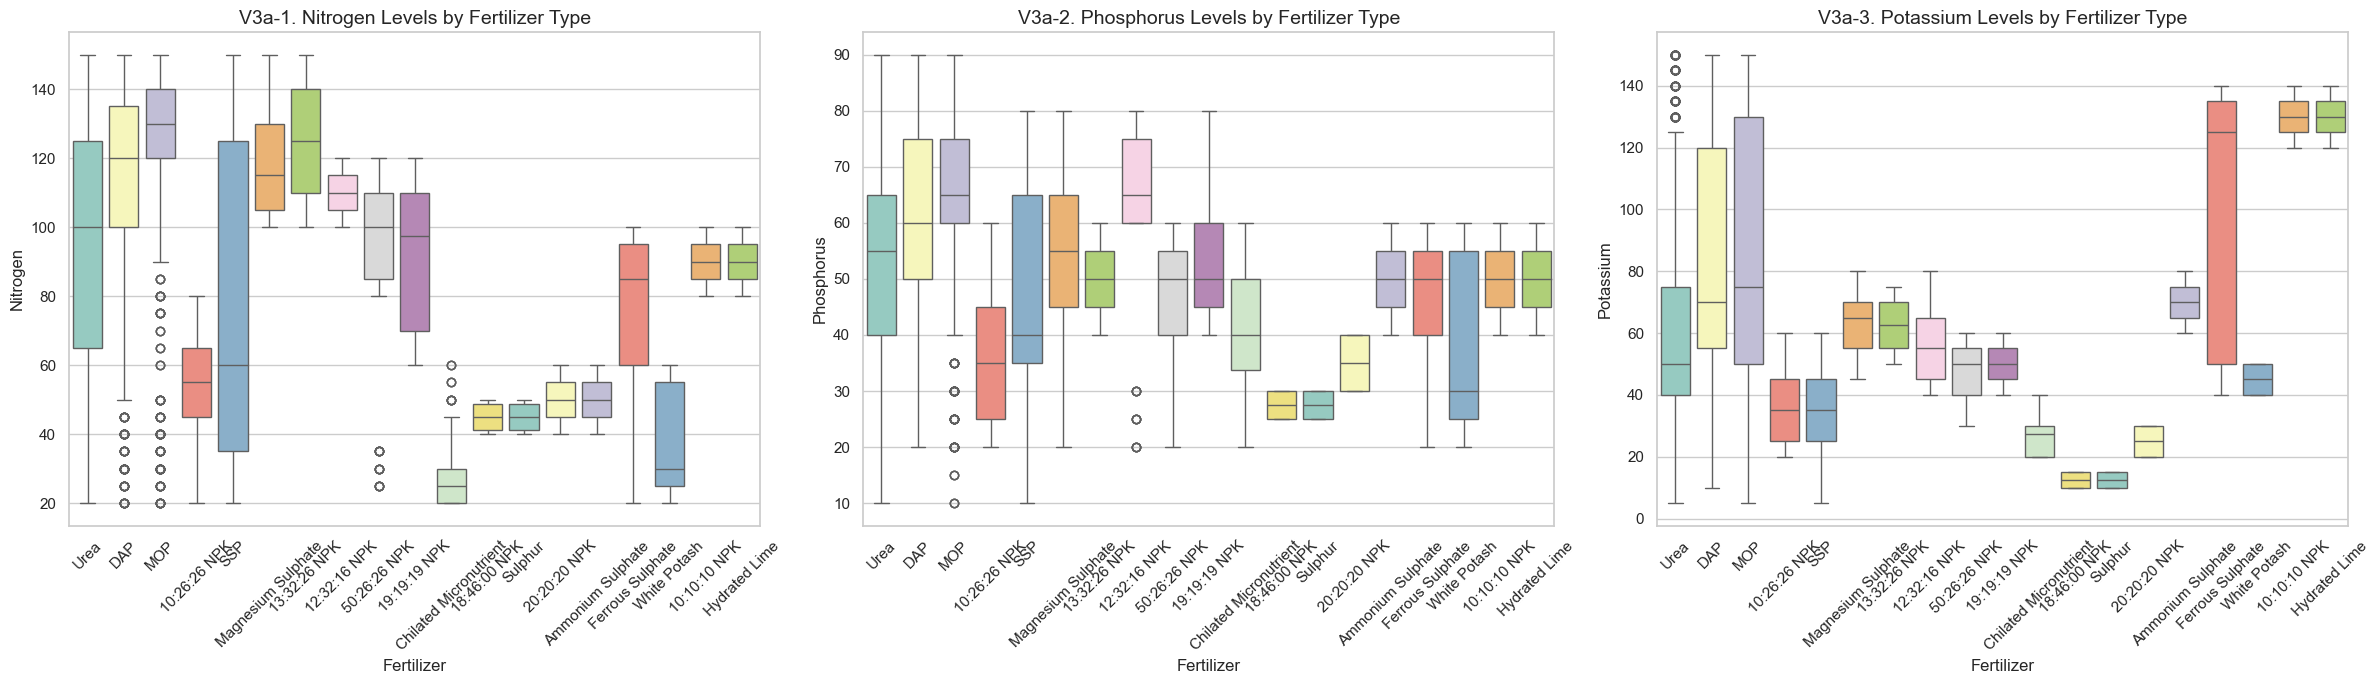

In [16]:
# V3. Bivariate Analysis: Nutrient Dependency on Target
# This is the most crucial plot, showing if a fertilizer type strongly dictates N, P, or K levels.
nutrients = ['Nitrogen', 'Phosphorus', 'Potassium']
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

for i, col in enumerate(nutrients):
    sns.boxplot(x=TARGET_COL, y=col, data=df_raw, ax=axes[i], palette='Set3')
    axes[i].set_title(f'V3a-{i+1}. {col} Levels by Fertilizer Type', fontsize=14)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
# Analysis Insight: Large separation between boxplots indicates high discriminative power for that nutrient.

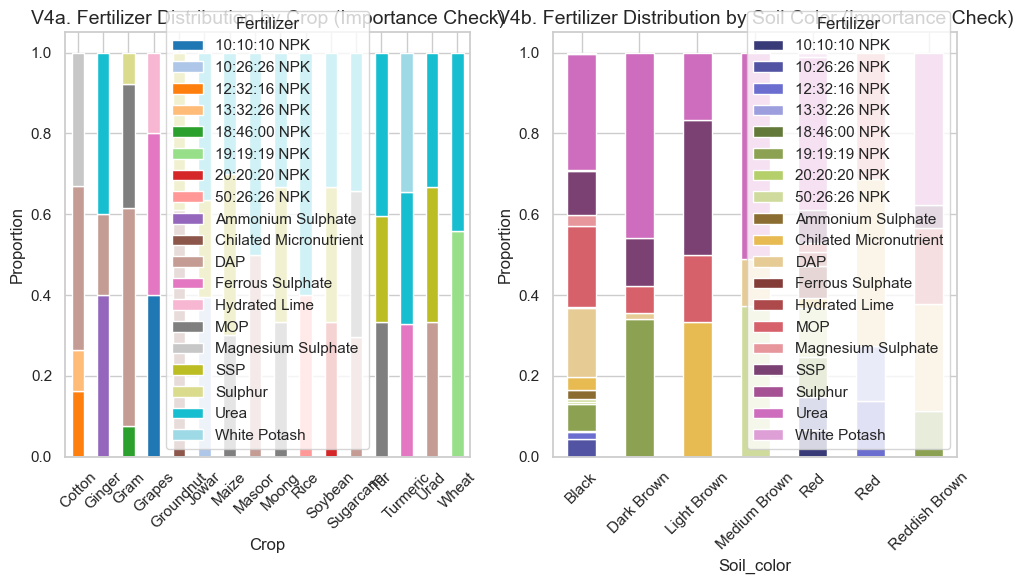

In [17]:
# V4. Bivariate Analysis: Categorical Influence on Target
# This confirms if 'Crop' and 'Soil_color' offer unique splits needed for the model.
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# V4a: Fertilizer Distribution by Crop
cross_tab_crop = pd.crosstab(df_raw['Crop'], df_raw[TARGET_COL], normalize='index')
cross_tab_crop.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20', ax=axes[0])
axes[0].set_title('V4a. Fertilizer Distribution by Crop (Importance Check)', fontsize=14)
axes[0].set_ylabel('Proportion', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# V4b: Fertilizer Distribution by Soil Color
cross_tab_soil = pd.crosstab(df_raw['Soil_color'], df_raw[TARGET_COL], normalize='index')
cross_tab_soil.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20b', ax=axes[1])
axes[1].set_title('V4b. Fertilizer Distribution by Soil Color (Importance Check)', fontsize=14)
axes[1].set_ylabel('Proportion', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
# Analysis Insight: Distinct color patterns show that Ordinal Encoding these features is justified, 
# as they significantly influence the target.

In [18]:
# --- 3. Preprocessing (From train_and_save.py) ---
print("\n--- 3. Preprocessing (Kaggle Notebook Style) ---")
df = df_raw.copy()

# Remove columns deemed unnecessary in the notebook
columns_to_remove = ['District_Name', 'Link']
df = df.drop(columns=columns_to_remove, errors='ignore')

# Handle potential null values (if any)
df = df.dropna()
print(f"After dropping columns and NaNs, shape: {df.shape}")

# --- Ordinal Encoding (Mapping) ---
soil_colors = df['Soil_color'].unique()
crops = df['Crop'].unique()

soil_color_mapping = {val: i for i, val in enumerate(soil_colors)}
crop_mapping = {val: i for i, val in enumerate(crops)}

df['Soil_color'] = df['Soil_color'].map(soil_color_mapping)
df['Crop'] = df['Crop'].map(crop_mapping)

print("Ordinal encoding complete. Features are now all numeric.")

# Target Encoding (Y)
le = LabelEncoder()
df[TARGET_COL] = le.fit_transform(df[TARGET_COL])
y = df[TARGET_COL].values
NUM_CLASSES = len(le.classes_)
TARGET_NAMES = list(le.classes_)
print(f"Target classes: {NUM_CLASSES}")

# Define Features (X)
X_df = df.drop(columns=[TARGET_COL])
X_feature_names = X_df.columns.tolist()

# Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X_df)
N_FEATURES = X.shape[1]

print(f"Feature matrix shape: {X.shape}. Total features: {N_FEATURES}")

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
print(f"Train/Test Split: {X_train.shape} / {X_test.shape}")


--- 3. Preprocessing (Kaggle Notebook Style) ---
After dropping columns and NaNs, shape: (4513, 9)
Ordinal encoding complete. Features are now all numeric.
Target classes: 19
Feature matrix shape: (4513, 8). Total features: 8
Train/Test Split: (3610, 8) / (903, 8)


In [19]:
# --- 4. Baseline Accuracy Check ---
print("\n--- 4. Baseline Accuracy Check ---\n")
# Calculate most frequent class baseline
most_frequent_class = Counter(y_train).most_common(1)[0]
baseline_acc = most_frequent_class[1] / len(y_train)
print(f"Most frequent class: {le.inverse_transform([most_frequent_class[0]])[0]} (Index {most_frequent_class[0]})")
print(f"Baseline (predicting most frequent): {baseline_acc:.4f}")

# Verify with DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_acc = dummy_clf.score(X_test, y_test)
print(f"DummyClassifier Test Accuracy: {dummy_acc:.4f} (Confirms baseline)")


--- 4. Baseline Accuracy Check ---

Most frequent class: Urea (Index 17)
Baseline (predicting most frequent): 0.3022
DummyClassifier Test Accuracy: 0.3023 (Confirms baseline)


In [20]:
# --- 5. Model Optimization (Manual Grid Search) ---
print("\n--- 5. Model Optimization (Using CORRECTED Custom Models) ---")
results = {}
best_score = -1
best_model = None
best_model_name = ""
total_start_time = time.time()

# --- 5a. Custom Random Forest Grid ---
rf_params_grid = {
    'n_trees': [50, 100, 200],
    'max_depth': [10, 20, 30]
}

print("\nStarting Random Forest Grid Search...")
for n_trees in rf_params_grid['n_trees']:
    for max_depth in rf_params_grid['max_depth']:
        model_name = f'RF_T{n_trees}_D{max_depth}'
        print(f"  Testing {model_name}...")
        
        rf_model = RandomForestClassifier(n_trees=n_trees, max_depth=max_depth)
        try:
            start_train = time.time()
            rf_model.fit(X_train, y_train)
            y_pred = rf_model.predict(X_test)
            score = accuracy_score(y_test, y_pred)
            duration = time.time() - start_train
            print(f"    -> Accuracy: {score:.4f} (Time: {duration:.2f}s)")
            results[model_name] = score

            if score > best_score:
                best_score = score
                best_model = rf_model
                best_model_name = model_name
        except Exception as e:
            print(f"    -> Training failed for {model_name}. Error: {e}")

# --- 5b. Custom SimpleMLP Grid (Aggressive) ---\
mlp_params_grid = {
    'n_hidden': [32, 64, 128],
    'learning_rate': [0.01, 0.05],
    'n_iters': [5000, 10000] 
}

print("\nStarting SimpleMLP Grid Search...")
for n_hidden in mlp_params_grid['n_hidden']:
    for lr in mlp_params_grid['learning_rate']:
        for n_iters in mlp_params_grid['n_iters']:
            model_name = f'MLP_H{n_hidden}_LR{lr}_I{n_iters}'
            print(f"  Testing {model_name}...")
            
            mlp_model = SimpleMLP(
                n_input=N_FEATURES, n_hidden=n_hidden, n_output=NUM_CLASSES, 
                learning_rate=lr, n_iters=n_iters, verbose=False, activation='relu' 
            )
            try:
                start_train = time.time()
                mlp_model.fit(X_train, y_train)
                y_pred = mlp_model.predict(X_test)
                score = accuracy_score(y_test, y_pred)
                duration = time.time() - start_train
                print(f"    -> Accuracy: {score:.4f} (Time: {duration:.2f}s)")
                results[model_name] = score

                if score > best_score:
                    best_score = score
                    best_model = mlp_model
                    best_model_name = model_name
            except Exception as e:
                print(f"    -> Training failed for {model_name}. Error: {e}")
            
if best_model is None:
    print("\n❌ Training failed for all critical models.")
else:
    total_end_time = time.time()
    print(f"\nTotal optimization time: {total_end_time - total_start_time:.2f} seconds.")
    print(f"\n✅ Optimization Complete. Best Model: **{best_model_name}** with Accuracy: **{best_score:.4f}**")


--- 5. Model Optimization (Using CORRECTED Custom Models) ---

Starting Random Forest Grid Search...
  Testing RF_T50_D10...
Fitting Random Forest: 50 trees, max_depth=10, min_split=2, features_per_split=2...
  Tree 5/50 fitted.
  Tree 10/50 fitted.
  Tree 15/50 fitted.
  Tree 20/50 fitted.
  Tree 25/50 fitted.
  Tree 30/50 fitted.
  Tree 35/50 fitted.
  Tree 40/50 fitted.
  Tree 45/50 fitted.
  Tree 50/50 fitted.
Random Forest fitting complete.
Predicting labels for 903 samples using Random Forest (50 trees)...
    -> Accuracy: 0.6312 (Time: 3.67s)
  Testing RF_T50_D20...
Fitting Random Forest: 50 trees, max_depth=20, min_split=2, features_per_split=2...
  Tree 5/50 fitted.
  Tree 10/50 fitted.
  Tree 15/50 fitted.
  Tree 20/50 fitted.
  Tree 25/50 fitted.
  Tree 30/50 fitted.
  Tree 35/50 fitted.
  Tree 40/50 fitted.
  Tree 45/50 fitted.
  Tree 50/50 fitted.
Random Forest fitting complete.
Predicting labels for 903 samples using Random Forest (50 trees)...
    -> Accuracy: 0.7929 (T

Predicting labels for 903 samples using Random Forest (200 trees)...

--- Classification Report for Best Model ---
                        precision    recall  f1-score   support

          10:10:10 NPK       1.00      1.00      1.00        10
          10:26:26 NPK       0.86      0.81      0.83        31
          12:32:16 NPK       0.63      0.90      0.75        21
          13:32:26 NPK       1.00      1.00      1.00        13
          18:46:00 NPK       0.50      1.00      0.67         1
          19:19:19 NPK       0.83      0.93      0.88        96
          20:20:20 NPK       1.00      1.00      1.00         3
          50:26:26 NPK       0.96      0.92      0.94        25
     Ammonium Sulphate       1.00      1.00      1.00        10
Chilated Micronutrient       0.74      0.91      0.82        22
                   DAP       0.85      0.81      0.83       134
      Ferrous Sulphate       1.00      0.93      0.96        14
         Hydrated Lime       1.00      1.00      1.0

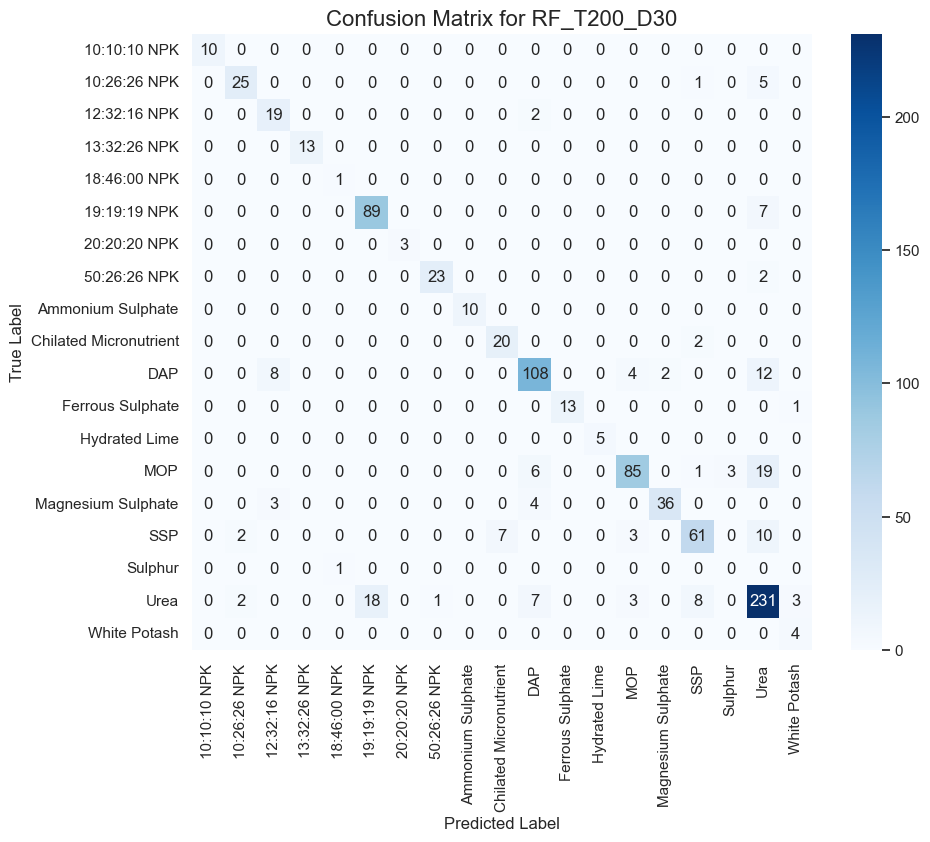

In [21]:
### Final Evaluation of the Best Model
if best_model:
    # Get predictions from the best model
    y_pred_best = best_model.predict(X_test)
    
    print("\n--- Classification Report for Best Model ---")
    print(classification_report(y_test, y_pred_best, target_names=TARGET_NAMES))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_best)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=TARGET_NAMES, yticklabels=TARGET_NAMES)
    plt.title(f'Confusion Matrix for {best_model_name}', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()
else:
    print("❌ Cannot perform final evaluation as no best model was found.")

In [22]:
# --- 6. Saving Model Pipeline ---
print("\n--- 6. Saving Model Pipeline ---")
if best_model:
    pipeline_components = {
        'model': best_model,
        'label_encoder_target': le, 
        'scaler': scaler, 
        'feature_columns': X_feature_names,
        'soil_color_mapping': soil_color_mapping,
        'crop_mapping': crop_mapping,
        'target_names': TARGET_NAMES
    }
    
    try:
        with open(OUTPUT_FILENAME, 'wb') as f:
            pickle.dump(pipeline_components, f)
        print(f"✅ Successfully saved pipeline components to '{OUTPUT_FILENAME}'")
    except Exception as e:
        print(f"❌ ERROR saving pipeline: {e}")
else:
    print("❌ No best model found to save.")


--- 6. Saving Model Pipeline ---
✅ Successfully saved pipeline components to 'fertilizer_recommendation_pipeline.pkl'
